In [11]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from torch.nn import functional as F

In [12]:
# Data Augmentation and normalization for training
# Only normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [24]:
data_dir = 'hymenoptera_data'
image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                      for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
                for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [25]:
def show_image(data, title=None):
    data = data.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    data = std * data + mean
    data = np.clip(data, 0, 1)
    plt.imshow(data)
    if title:
        plt.title(title)
    plt.pause(0.001) # pause for plot update

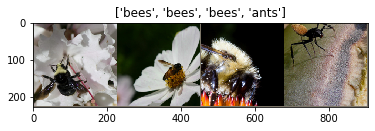

In [26]:
images, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(images)

show_image(out, title=[class_names[x] for x in classes])

In [71]:
class BeeAntClassifier(pl.LightningModule):
    def __init__(self,hparams):
        super().__init__()
        self.hparams = hparams
        num_target_classes = 2
        self.feature_extractor = torchvision.models.resnet18(pretrained=True)
        
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
        
        num_ftrs = self.feature_extractor.fc.in_features
        self.feature_extractor.fc = nn.Linear(num_ftrs, num_target_classes)
        
        
    def forward(self, x):
        x = self.feature_extractor(x)
        return x

    def prepare_data(self):
        data_transforms = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        }
        
        data_dir = 'hymenoptera_data'
        self.train_set = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train'])
        self.val_set = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val'])
   
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_set, batch_size=self.hparams['batch_size'], shuffle=True, num_workers=4)
    
    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_set, batch_size=self.hparams['batch_size'], num_workers=4)
    
    def general_step(self, batch, batch_idx):
        images, targets = batch
        out = self.forward(images)
        loss = F.cross_entropy(out, targets)
        
        preds = out.argmax(axis=1)
        acc = (targets == preds).float().mean()
        
        return loss, acc
    
    def training_step(self, batch, batch_idx):
        loss, acc = self.general_step(batch, batch_idx)
        logs = {'train_loss': loss, 'train_acc': acc}
        return {'loss': loss, 'log': logs}

    def validation_step(self, batch, batch_idx):
        loss, acc = self.general_step(batch, batch_idx)
        logs = {'val_loss': loss, 'val_acc': acc}
        return {'val_loss': loss, 'val_acc': acc, 'log': logs}
    
    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in outputs]).sum()
        avg_acc /= len(outputs)
        logs = {'val_loss': avg_loss, 'val_acc': avg_acc}
        return {'val_loss': avg_loss, 'log': logs}
    
    def configure_optimizers(self):
        opt = optim.SGD(self.parameters(), lr=self.hparams['learning_rate'], momentum=0.9)
        scheduler = optim.lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)
        return [opt], [scheduler]

In [72]:
hparams = {
    'batch_size': 4,
    'learning_rate': 1e-3
}

In [73]:
model = BeeAntClassifier(hparams)
trainer = pl.Trainer(gpus=1, profiler=True, max_epochs=25)
trainer.fit(model)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

   | Name                                    | Type              | Params
--------------------------------------------------------------------------
0  | feature_extractor                       | ResNet            | 11 M  
1  | feature_extractor.conv1                 | Conv2d            | 9 K   
2  | feature_extractor.bn1                   | BatchNorm2d       | 128   
3  | feature_extractor.relu                  | ReLU              | 0     
4  | feature_extractor.maxpool               | MaxPool2d         | 0     
5  | feature_extractor.layer1                | Sequential        | 147 K 
6  | feature_extractor.layer1.0              | BasicBlock        | 73 K  
7  | feature_extractor.layer1.0.conv1        | Conv2d            | 36 K  
8  | feature_extractor.layer1.0.bn1          | BatchNorm2d       | 128   
9  | feature_extractor.layer1.0.relu         | ReLU              | 0 



Profiler Report

Action              	|  Mean duration (s)	|  Total time (s) 
-----------------------------------------------------------------
on_train_start      	|  0.016          	|  0.016          
on_epoch_start      	|  0.00252        	|  0.063          
get_train_batch     	|  0.091065       	|  141.15         
on_batch_start      	|  9.8361e-06     	|  0.015          
model_forward       	|  0.014922       	|  22.756         
model_backward      	|  0.00077967     	|  1.189          
on_after_backward   	|  0.0            	|  0.0            
optimizer_step      	|  0.00055344     	|  0.844          
on_batch_end        	|  0.0017167      	|  2.618          
on_epoch_end        	|  0.0            	|  0.0            
on_train_end        	|  0.0            	|  0.0            



1

In [77]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                show_image(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

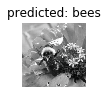

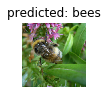

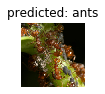

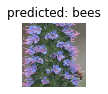

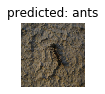

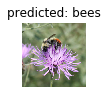

In [78]:
visualize_model(model)